# Bibliotecas

In [59]:
import pyedflib
import numpy as np
import pandas as pd
import commands
import pywt
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from pywt import WaveletPacket
import pywt.data
from detect_peaks import detect_peaks
%matplotlib notebook

---

## Filtros

In [60]:
def FilterSignal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = emg_filtered
    #emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    #return emg_envelope
    return emg_filtered

## Função FFT

In [251]:
def Fft(file_):
    
    #Lê dados dos arquivos .edf
    #file_name = pyedflib.EdfReader('DB_REPO/edf/'+file_)    
    #n = file_name.signals_in_file
    #signal_labels = file_name.getSignalLabels()
    #sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    #for j in np.arange(n):
    #     sigbufs[j, :] = file_name.readSignal(j)

    #file_name._close()

    #df = pd.DataFrame(np.transpose(sigbufs))
    ##df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    
    file_name = np.load('DB_REPO/preproc/'+file_+'_std.npy')

    if file_name.shape[1] == 4:
    #if len(df.columns) == 4:
    
        df = pd.DataFrame(data=file_name, columns=['Ch1','Ch2','Ch3','Ch4'])
        
        #Nomeia cada coluna "canal"
        #df = df.rename(columns={0: 'Ch1'})
        #df = df.rename(columns={1: 'Ch2'})
        #df = df.rename(columns={2: 'Ch3'})
        #df = df.rename(columns={3: 'Ch4'})
    
    if file_name.shape[1] == 3:
    #if len(df.columns) == 3:
    
        df = pd.DataFrame(data=file_name, columns=['Ch1','Ch2','Ch3','Ch4'])

        #df = df.rename(columns={0: 'Ch1'})
        #df = df.rename(columns={1: 'Ch2'})
        #df = df.rename(columns={2: 'Ch3'})
            

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    def fft(dfa):
        
        for i in range(dfa.shape[1]):
            if i == 0:
                Xc = np.abs(np.fft.fft(dfa[:, i]))
            else:
                Xcp = np.abs(np.fft.fft(dfa[:, i]))
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)
    
    
    #Aplica FFT em cada canal
    fft = fft(dfa)
    if len(df.columns) == 4:
        fft = pd.DataFrame(data=fft, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    if len(df.columns) == 3:
        fft = pd.DataFrame(data=fft, columns=['Ch1','Ch2','Ch3'])
        
    return fft

In [4]:
def PlotFft(Xc, F):
    #Xc = dfn['Ch1']
    ff, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    fs = np.linspace(0, F,Xc['Ch1'].shape[0])
    ax1.plot(fs,Xc['Ch1'], linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    fs = np.linspace(0, F,Xc['Ch2'].shape[0])
    ax2.plot(fs,Xc['Ch2'], linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    fs = np.linspace(0, F,Xc['Ch3'].shape[0])
    ax3.plot(fs,Xc['Ch3'], linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    fs = np.linspace(0, F,Xc['Ch4'].shape[0])
    ax4.plot(fs,Xc['Ch4'], linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in ff.axes[:-1]], visible=False)
    ff.set_size_inches(w=10,h=8)

## Função Plot

In [5]:
def PlotFile(dfn):
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    ax1.plot(dfn['Ch1'][2000:], linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax2.plot(dfn['Ch2'][2000:], linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax3.plot(dfn['Ch3'][2000:], linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax4.plot(dfn['Ch4'][2000:], linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    f.set_size_inches(w=10,h=8)

## Função RMS

In [47]:
def Rms(file_):

    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)
    
    #Lê dados dos arquivos .edf
    #file_name = pyedflib.EdfReader('DB_REPO/preproc/'+file_+'_std.npy')    
    #n = file_name.signals_in_file
    #signal_labels = file_name.getSignalLabels()
    #sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    #for j in np.arange(n):
    #     sigbufs[j, :] = file_name.readSignal(j)

    #file_name._close()

    #df = pd.DataFrame(np.transpose(sigbufs))
    ##df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    file_name = np.load('DB_REPO/preproc/'+file_+'_std.npy')

    if file_name.shape[1] == 4:
    #if len(df.columns) == 4:
    
        df = pd.DataFrame(data=file_name, columns=['Ch1','Ch2','Ch3','Ch4'])
        
        #Nomeia cada coluna "canal"
        #df = df.rename(columns={0: 'Ch1'})
        #df = df.rename(columns={1: 'Ch2'})
        #df = df.rename(columns={2: 'Ch3'})
        #df = df.rename(columns={3: 'Ch4'})
    
    if file_name.shape[1] == 3:
    #if len(df.columns) == 3:

        df = pd.DataFrame(data=file_name, columns=['Ch1','Ch2','Ch3'])
        #df = df.rename(columns={0: 'Ch1'})
        #df = df.rename(columns={1: 'Ch2'})
        #df = df.rename(columns={2: 'Ch3'})
            

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    if len(df.columns) == 4:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    if len(df.columns) == 3:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3'])
        
    return rms

---

In [9]:
import commands
A = commands.getoutput('ls DB_REPO/edf')
A.split('\n')

['CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf',
 'CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf',
 'CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf',
 'CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf',
 'CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf',
 'CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf',
 'CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf',
 'CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf',
 'CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf',
 'CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf',
 'CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf',
 'CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf',
 'CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.19.edf',
 'CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.35.edf',
 'CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.52.edf',
 'CT_Joaquina de Sousa Freitas  - Dia 17.12

In [10]:
files = ['CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf',
 'CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf',
 'CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf',
 'CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf',
 'CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf',
 'CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf',
 'CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf',
 'CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf',
 'CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf',
 'CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf',
 'CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf',
 'CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf',
 'CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.19.edf',
 'CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.35.edf',
 'CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.52.edf',
 'CT_Joaquina de Sousa Freitas  - Dia 17.12.13 as 11.00.17.edf',
 'CT_Joaquina de Sousa Freitas  - Dia 17.12.13 as 11.00.35.edf',
 'CT_Joaquina de Sousa Freitas  - Dia 17.12.13 as 11.00.53.edf',
 'CT_Jose Martins de Sousa  - Dia 17.12.13 as 09.29.49.edf',
 'CT_Jose Martins de Sousa  - Dia 17.12.13 as 09.30.07.edf',
 'CT_Jose Martins de Sousa  - Dia 17.12.13 as 09.30.21.edf',
 'CT_Larcir Iria da Conceicao Santos - Dia 17.12.11 as 10.46.03.edf',
 'CT_Larcir Iria da Conceicao Santos - Dia 17.12.11 as 10.46.28.edf',
 'CT_Larcir Iria da Conceicao Santos - Dia 17.12.11 as 10.46.44.edf',
 'CT_Magda Aparecida Ferreira - Dia 17.12.11 as 09.17.13.edf',
 'CT_Magda Aparecida Ferreira - Dia 17.12.11 as 09.17.28.edf',
 'CT_Magda Aparecida Ferreira - Dia 17.12.11 as 09.17.48.edf',
 'CT_Manuel Saraiva da Rocha - Dia 17.12.13 as 08.49.04.edf',
 'CT_Manuel Saraiva da Rocha - Dia 17.12.13 as 08.49.44.edf',
 'CT_Manuel Saraiva da Rocha - Dia 17.12.13 as 08.50.05.edf',
 'CT_Maria das Gracas Vieira - Dia 17.12.11 as 11.29.00.edf',
 'CT_Maria das Gracas Vieira - Dia 17.12.11 as 11.29.14.edf',
 'CT_Maria das Gracas Vieira - Dia 17.12.11 as 11.29.29.edf',
 'CT_Maria Santana Estevam Moreira - Dia 17.12.13 as 11.20.46.edf',
 'CT_Maria Santana Estevam Moreira - Dia 17.12.13 as 11.21.44.edf',
 'CT_Maria Santana Estevam Moreira - Dia 17.12.13 as 11.22.01.edf',
 'CT_Maria Veira Borges - Dia 17.12.11 as 10.31.12.edf',
 'CT_Maria Veira Borges - Dia 17.12.11 as 10.31.27.edf',
 'CT_Maria Veira Borges - Dia 17.12.11 as 10.31.48.edf',
 'CT_Zenobia Barroso Feitosa - Dia 17.12.11 as 09.37.57.edf',
 'CT_Zenobia Barroso Feitosa - Dia 17.12.11 as 09.38.11.edf',
 'CT_Zenobia Barroso Feitosa - Dia 17.12.11 as 09.38.25.edf',
 'PK_Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf',
 'PK_Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf',
 'PK_Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf',
 'PK_Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf',
 'PK_Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf',
 'PK_Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf',
 'PK_Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf',
 'PK_Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf',
 'PK_Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf',
 'PK_Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf',
 'PK_Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf',
 'PK_Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf',
 'PK_Donia Aires - Dia 17.11.25 as 16.39.51.edf',
 'PK_Donia Aires - Dia 17.11.25 as 16.40.23.edf',
 'PK_Donia Aires - Dia 17.11.25 as 16.40.42.edf',
 'PK_Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf',
 'PK_Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf',
 'PK_Fernando Francisco da Silva - Dia 17.11.18 as 17.06.32.edf',
 'PK_Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.35.edf',
 'PK_Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.56.edf',
 'PK_Gastao Goncalves da Silva - Dia 17.11.18 as 16.28.12.edf',
 'PK_Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.28.edf',
 'PK_Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.44.edf',
 'PK_Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.59.09.edf',
 'PK_Ivanildes Barbosa - Dia 17.11.18 as 16.44.01.edf',
 'PK_Ivanildes Barbosa - Dia 17.11.18 as 16.44.19.edf',
 'PK_Ivanildes Barbosa - Dia 17.11.18 as 16.44.37.edf',
 'PK_Jose Fernandes Araujo - Dia 17.11.25 as 17.15.42.edf',
 'PK_Jose Fernandes Araujo - Dia 17.11.25 as 17.16.0.edf',
 'PK_Jose Fernandes Araujo - Dia 17.11.25 as 17.16.28.edf',
 'PK_Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.21.edf',
 'PK_Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.34.edf',
 'PK_Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.49.edf',
 'PK_Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.18.51.edf',
 'PK_Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.07.edf',
 'PK_Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.23.edf',
 'PK_Osvaldir Borborema - Dia 17.11.18 as 15.14.36.edf',
 'PK_Osvaldir Borborema - Dia 17.11.18 as 15.14.58.edf',
 'PK_Osvaldir Borborema - Dia 17.11.18 as 15.15.13.edf',
 'PK_Sergio Lamenza - Dia 17.11.25 as 16.58.15.edf',
 'PK_Sergio Lamenza - Dia 17.11.25 as 16.58.34.edf',
 'PK_Sergio Lamenza - Dia 17.11.25 as 16.59.00.edf']



## Plota Sinal Puro

In [42]:
file_name = pyedflib.EdfReader('DB_REPO/edf/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf')

n = file_name.signals_in_file
signal_labels = file_name.getSignalLabels()
sigbufs = np.zeros((n, file_name.getNSamples()[0]))
for j in np.arange(n):
     sigbufs[j, :] = file_name.readSignal(j)

file_name._close()

dfp = pd.DataFrame(np.transpose(sigbufs))
sp = dfp.as_matrix()

dff = pd.DataFrame(data=sp, columns=['Ch1','Ch2','Ch3','Ch4'])
dff.head()

Ch1    Ch2       Ch3        Ch4
0  17.822388  3.564 -6.643478 -29.850382
1  20.670149 -2.164  1.965217 -35.508397
2  19.246269  7.860  4.834783 -34.093893
3  19.246269  4.996  1.965217 -28.435878
4  17.822388  2.132  4.834783 -34.093893

Sinal Puro


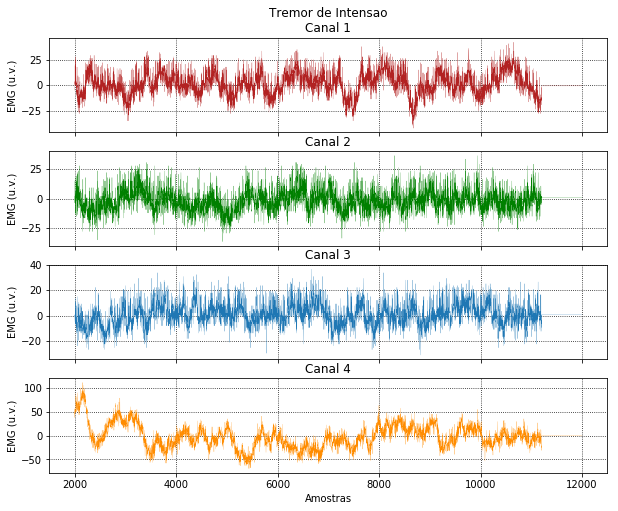

In [35]:
print ('Sinal Puro')
PlotFile(dff)

## Calcula a Norma de cada canal

In [11]:
#files = ['p1', 'p2', 'p3', 'p4', 'p5', 'c1', 'c2', 'c3', 'c4', 'c5']


peaks_rms_4ch = [ ]
peaks_rms_3ch = [ ]



def Norm(file_):
    
    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)  

    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_REPO/edf/'+file_)    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    if len(df.columns) == 4:
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
        df = df.rename(columns={3: 'Ch4'})


    if len(df.columns) == 3:
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    if len(df.columns) == 4:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
        
        #Calcula o pico RMS máximo de cada canal em cada arquivo e adiciona a lista peaks_rms
        peaks_rms_4ch.append([max(rms['Ch1']),max(rms['Ch2']),max(rms['Ch3']),max(rms['Ch4']),])
    
    if len(df.columns) == 4:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3'])
        
        #Calcula o pico RMS máximo de cada canal em cada arquivo e adiciona a lista peaks_rms
        peaks_rms_3ch.append([max(rms['Ch1']),max(rms['Ch2']),max(rms['Ch3']),])
        
    return df

#Cria a lista de picos RMS máximo    
for i in files:
    Norm(i)

#Calcula o máximo global
peaks_rms_4ch = pd.DataFrame(data=peaks_rms_4ch, columns=['Ch1','Ch2','Ch3','Ch4'])
norm_4ch = [max(peaks_rms_4ch['Ch1']),max(peaks_rms_4ch['Ch2']),max(peaks_rms_4ch['Ch3']),max(peaks_rms_4ch['Ch4'])]  

peaks_rms_3ch = pd.DataFrame(data=peaks_rms_3ch, columns=['Ch1','Ch2','Ch3'])
norm_3ch = [max(peaks_rms_3ch['Ch1']),max(peaks_rms_3ch['Ch2']),max(peaks_rms_3ch['Ch3'])]  

norm = norm_3ch + norm_4ch
print 'Norma de cada canal: \n',norm

Norma de cada canal: 
[473.6481195965282, 2960.1764354868283, 108.6647994824209, 473.6481195965282, 2960.1764354868283, 108.6647994824209, 1679.2835958385861]


---

## Aplica a norma em cada amostra e salva

In [252]:
def Std(file_):

    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_REPO/edf/'+file_)    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    dfa = df.as_matrix()
    
    if len(df.columns) == 4:

        #Aplica a norma em cada canal
        Xc=np.array([dfa[:,0]/norm_4ch[0],dfa[:,1]/norm_4ch[1],dfa[:,2]/norm_4ch[2],dfa[:,3]/norm_4ch[3]])
        Xc = np.transpose(Xc)
        #Salva o arquivo normalizado na pasta <preproc>
        np.save('./DB_REPO/preproc/'+file_+'_std', Xc, allow_pickle=False)
        print file_+'_std.npy'

        return(pd.DataFrame(data=Xc, columns=['Ch1','Ch2','Ch3','Ch4']))
    
    if len(df.columns) == 3:

        #Aplica a norma em cada canal
        Xc=np.array([dfa[:,0]/norm_3ch[0],dfa[:,1]/norm_3ch[1],dfa[:,2]/norm_3ch[2]])
        Xc = np.transpose(Xc)
        #Salva o arquivo normalizado na pasta <preproc>
        np.save('./DB_REPO/preproc/'+file_+'_std', Xc, allow_pickle=False)
        print file_+'_std.npy'

        return(pd.DataFrame(data=Xc, columns=['Ch1','Ch2','Ch3']))

In [253]:
for i in files:
    Std(i)

CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_std.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf_std.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf_std.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf_std.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf_std.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf_std.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf_std.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf_std.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf_std.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf_std.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf_std.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf_std.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.19.edf_std.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.35.edf_std.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.4

In [254]:
Std('CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf').head()

CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_std.npy


Ch1       Ch2       Ch3       Ch4
0  0.037628  0.001204 -0.061137 -0.017776
1  0.043640 -0.000731  0.018085 -0.021145
2  0.040634  0.002655  0.044493 -0.020303
3  0.040634  0.001688  0.018085 -0.016933
4  0.037628  0.000720  0.044493 -0.020303

In [255]:
c = np.load('DB_REPO/preproc/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_std.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

Ch1       Ch2       Ch3       Ch4
0  0.037628  0.001204 -0.061137 -0.017776
1  0.043640 -0.000731  0.018085 -0.021145
2  0.040634  0.002655  0.044493 -0.020303
3  0.040634  0.001688  0.018085 -0.016933
4  0.037628  0.000720  0.044493 -0.020303

Sinal Normalizado


<IPython.core.display.Javascript object>


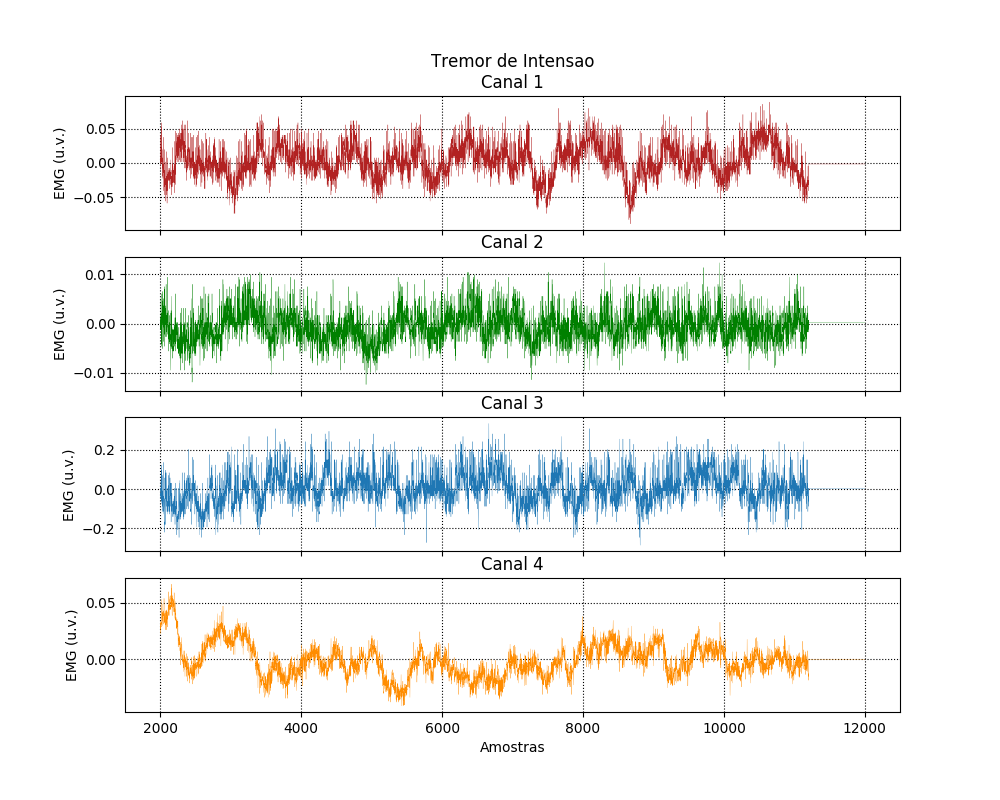

In [256]:
print ('Sinal Normalizado')
PlotFile(dfn)

In [48]:
for i in files:
    Xc = Rms(i)
    np.save('./DB_REPO/preproc/'+i+'_rms', Xc, allow_pickle=False)
    print i+'_rms.npy'

CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_rms.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf_rms.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf_rms.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf_rms.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf_rms.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf_rms.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf_rms.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf_rms.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf_rms.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf_rms.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf_rms.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf_rms.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.19.edf_rms.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.35.edf_rms.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.4

In [257]:
c = np.load('DB_REPO/preproc/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_rms.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

Ch1       Ch2       Ch3       Ch4
0  0.038075  0.002811  0.055433  0.017050
1  0.037774  0.002933  0.056032  0.017107
2  0.037403  0.003035  0.056188  0.016952
3  0.037097  0.003012  0.055893  0.016742
4  0.036828  0.003073  0.055839  0.016623

In [258]:
Rms('CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf').head()

Ch1       Ch2       Ch3       Ch4
0  0.038075  0.002811  0.055433  0.017050
1  0.037774  0.002933  0.056032  0.017107
2  0.037403  0.003035  0.056188  0.016952
3  0.037097  0.003012  0.055893  0.016742
4  0.036828  0.003073  0.055839  0.016623

<IPython.core.display.Javascript object>


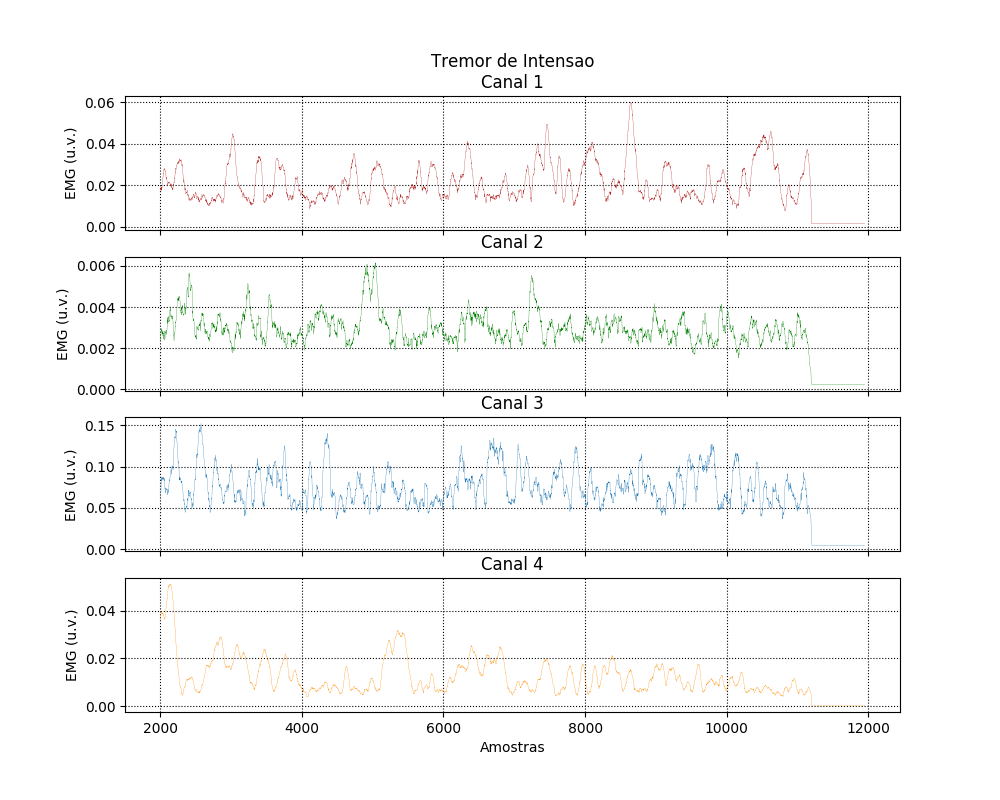

In [259]:
PlotFile(dfn)

In [62]:
for i in files:
    c = np.load('DB_REPO/preproc/'+i+'_rms.npy')
    
    if c.shape[1] ==  4:
        df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
        df = df.rename(columns={3: 'Ch4'})

        Xc = df.copy()
        Xc['Ch1'] = FilterSignal(df['Ch1'], low_pass=10)
        Xc['Ch2'] = FilterSignal(df['Ch2'], low_pass=10)
        Xc['Ch3'] = FilterSignal(df['Ch3'], low_pass=10)
        Xc['Ch4'] = FilterSignal(df['Ch4'], low_pass=10)

        np.save('./DB_REPO/preproc/'+i+'_filt', Xc, allow_pickle=False)
        print i+'_filt.npy'
        
    if c.shape[1] ==  3:
        df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3'])
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})

        Xc = df.copy()
        Xc['Ch1'] = FilterSignal(df['Ch1'], low_pass=10)
        Xc['Ch2'] = FilterSignal(df['Ch2'], low_pass=10)
        Xc['Ch3'] = FilterSignal(df['Ch3'], low_pass=10)

        np.save('./DB_REPO/preproc/'+i+'_filt', Xc, allow_pickle=False)
        print i+'_filt.npy'

CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_filt.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf_filt.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf_filt.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf_filt.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf_filt.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf_filt.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf_filt.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf_filt.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf_filt.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf_filt.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf_filt.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf_filt.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.19.edf_filt.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.35.edf_filt.npy
CT_Iraci Rodrigues Soares - Dia 17

In [260]:
c = np.load('DB_REPO/preproc/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_rms.npy')
    
df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
#Nomeia cada coluna "canal"
df = df.rename(columns={0: 'Ch1'})
df = df.rename(columns={1: 'Ch2'})
df = df.rename(columns={2: 'Ch3'})
df = df.rename(columns={3: 'Ch4'})

Xc = df.copy()
Xc['Ch1'] = FilterSignal(df['Ch1'], low_pass=10)
Xc['Ch2'] = FilterSignal(df['Ch2'], low_pass=10)
Xc['Ch3'] = FilterSignal(df['Ch3'], low_pass=10)
Xc['Ch4'] = FilterSignal(df['Ch4'], low_pass=10)

Xc.head()

Ch1       Ch2       Ch3       Ch4
0 -0.000215 -0.000047  0.000508 -0.000195
1 -0.000378  0.000051  0.000384 -0.000169
2 -0.000566  0.000098  0.000141 -0.000238
3 -0.000701  0.000100 -0.000549 -0.000388
4 -0.000685  0.000098 -0.001794 -0.000536

In [261]:
c = np.load('DB_REPO/preproc/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_filt.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

Ch1       Ch2       Ch3       Ch4
0 -0.000215 -0.000047  0.000508 -0.000195
1 -0.000378  0.000051  0.000384 -0.000169
2 -0.000566  0.000098  0.000141 -0.000238
3 -0.000701  0.000100 -0.000549 -0.000388
4 -0.000685  0.000098 -0.001794 -0.000536

<IPython.core.display.Javascript object>


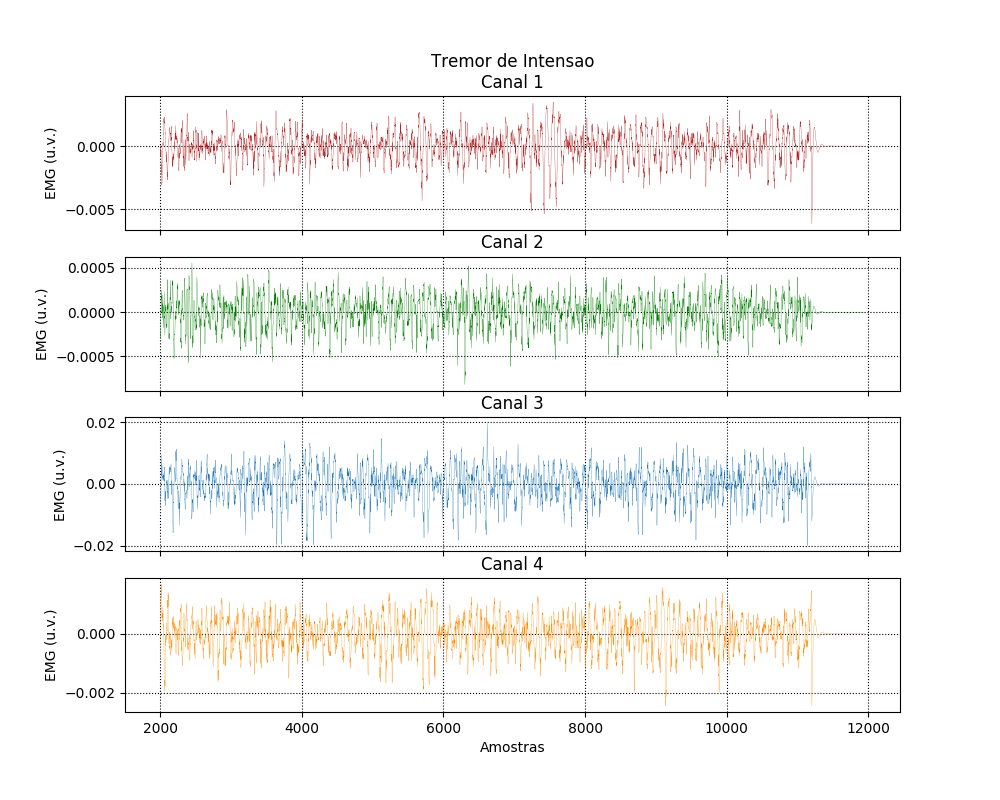

In [262]:
PlotFile(dfn)

<IPython.core.display.Javascript object>


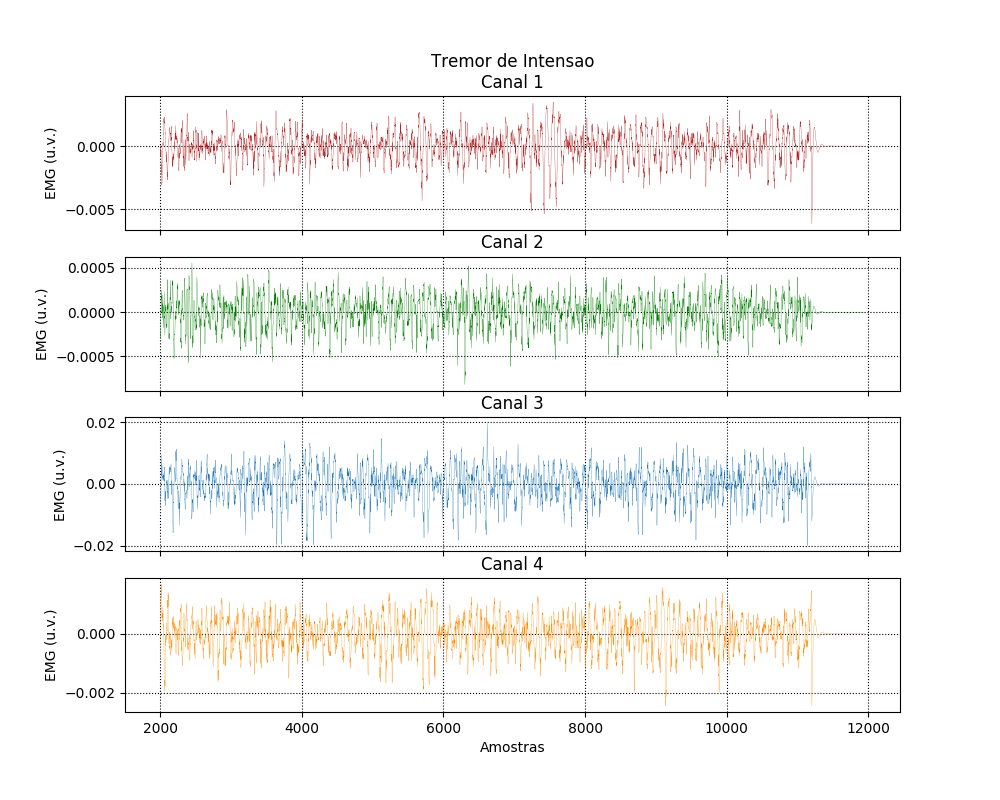

In [72]:
c = np.load('DB_REPO/preproc/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_filt.npy')
PlotFile(dfn)
#PlotFft(c, 50)

In [263]:
for i in files:
    Xc = Fft(i)
    np.save('./DB_REPO/preproc/'+i+'_fft', Xc, allow_pickle=False)
    print i+'_fft.npy'

CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_fft.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf_fft.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf_fft.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf_fft.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf_fft.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf_fft.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf_fft.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf_fft.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf_fft.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf_fft.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf_fft.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf_fft.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.19.edf_fft.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.35.edf_fft.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.4

In [264]:
c = np.load('DB_REPO/preproc/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_fft.npy')

dff = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dff.head()

Ch1       Ch2         Ch3        Ch4
0  33.739349  7.969901   57.111011  16.383163
1   4.466916  1.634172   80.956572  27.059718
2   5.788714  0.208211  112.327413  48.707758
3  17.831326  2.298649   45.931231   3.303747
4  36.755845  5.536845  114.746327  35.185469

<IPython.core.display.Javascript object>


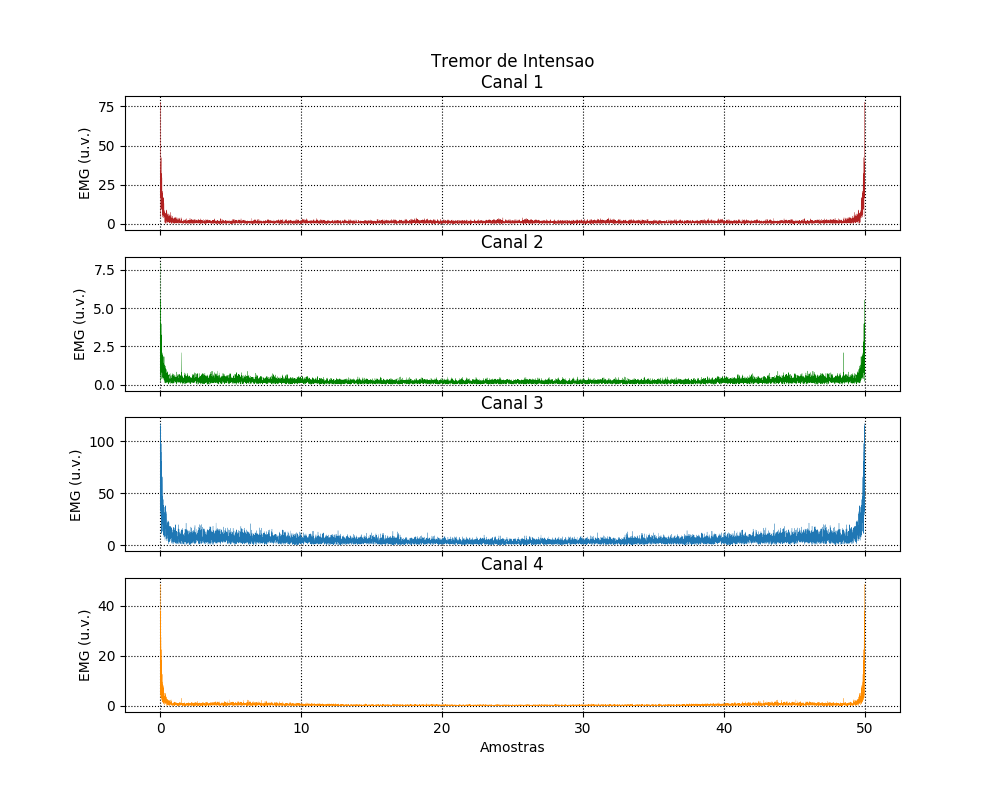

In [77]:
PlotFft(dff,50)

In [78]:
X = Fft('CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf')

In [79]:
X.head()

Ch1       Ch2         Ch3        Ch4
0  33.739349  7.969901   57.111011  16.383163
1   4.466916  1.634172   80.956572  27.059718
2   5.788714  0.208211  112.327413  48.707758
3  17.831326  2.298649   45.931231   3.303747
4  36.755845  5.536845  114.746327  35.185469

<IPython.core.display.Javascript object>


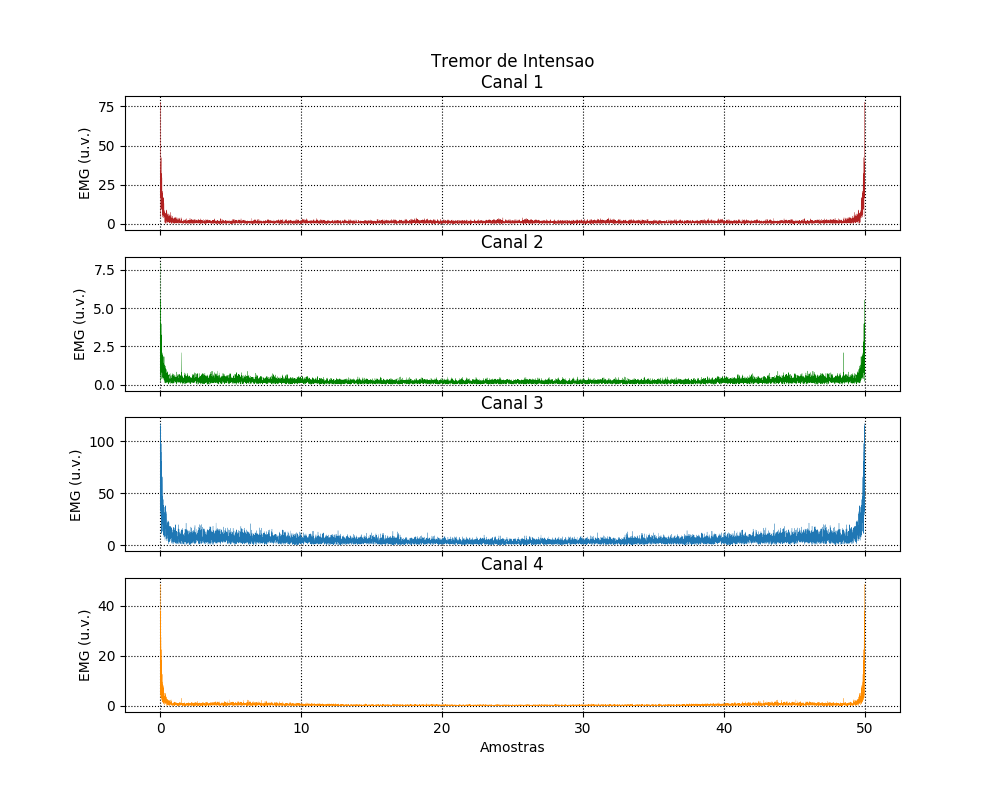

In [80]:
PlotFft(X,50)

In [229]:
def Var(a, window_size):
    def subf(a, window_size):
        Z = np.array([])
        for i in range(len(a)-window_size):
            Z = np.append(Z,np.var(a[i:window_size+i]))
        return Z
            
    for i in range(a.shape[1]):
        if i == 0:
            Xc = subf(a[:, i], window_size)
        else:
            Xcp = subf(a[:, i], window_size)
            Xc = np.vstack((Xc,Xcp))
    return np.transpose(Xc)

In [243]:
for i in files:
    Xc = Var(np.load('DB_REPO/preproc/'+i+'_std.npy'),49)
    np.save('./DB_REPO/preproc/'+i+'_var.npy', Xc, allow_pickle=False)
    print i+'_var.npy'

CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_var.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf_var.npy
CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf_var.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf_var.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf_var.npy
CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf_var.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf_var.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf_var.npy
CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf_var.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf_var.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf_var.npy
CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf_var.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.19.edf_var.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.43.35.edf_var.npy
CT_Iraci Rodrigues Soares - Dia 17.12.13 as 10.4

<IPython.core.display.Javascript object>


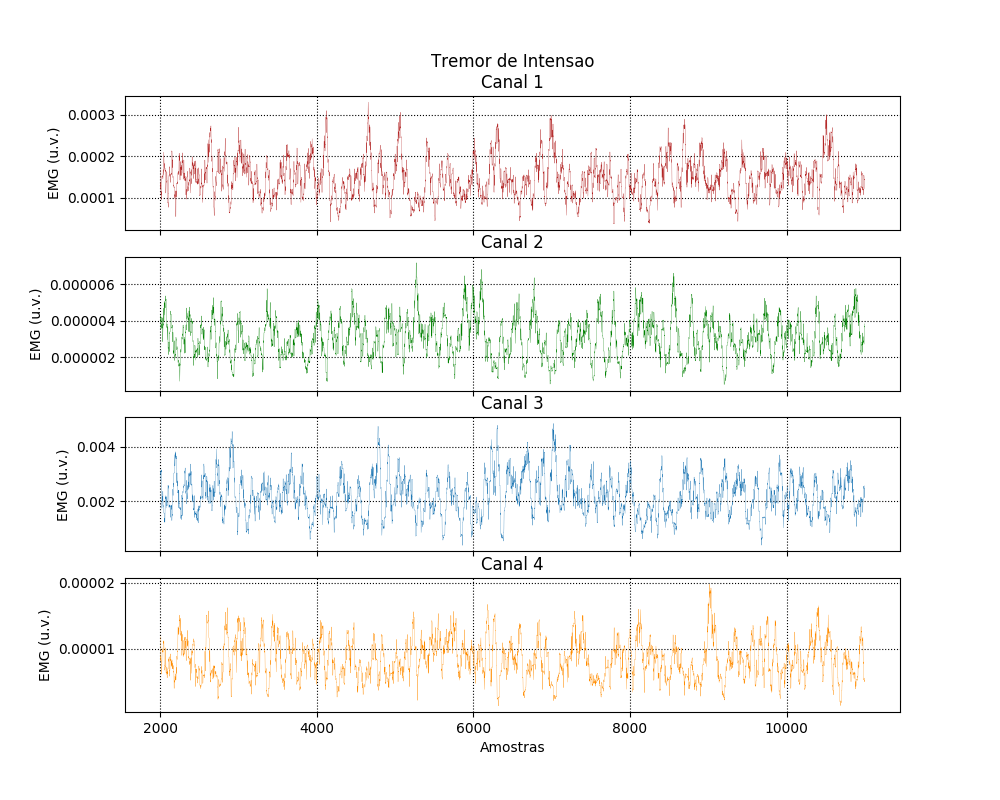

In [235]:
X = np.load('DB_REPO/preproc/CT_Joaquina de Sousa Freitas  - Dia 17.12.13 as 11.00.17.edf_std.npy')
X_var = f_var(X, 50)
dfv = pd.DataFrame(data=X_var, columns=['Ch1','Ch2','Ch3','Ch4'])
PlotFile(dfv[:11000])

In [202]:
def zc(X,alpha):
    zc = []

    for j in range(X.shape[1]):
        if j == 0:
            for i in range(1,X.shape[0]-1):
                if m.copysign(1, X[i,j]-alpha) != m.copysign(1, X[i-1,j]-alpha):
                #if (X[i,j]-alpha) > 0:
                    #zc.append(X[i-1,j]-alpha)
                    zc.append(1)
                else:
                    zc.append(0)
            zc = np.array(zc)

        else:
            zcp = []
            for i in range(1,X.shape[0]-1):
                if m.copysign(1, X[i,j]-alpha) != m.copysign(1, X[i-1,j]-alpha):
                #if (X[i,j]-alpha) > 0:
                    #zcp.append(X[i-1,j]-alpha)
                    zcp.append(1)
                else:
                    zcp.append(0)
            zcp = np.array(zcp)
            zc = np.vstack((zc,zcp))

    return np.transpose(zc)


In [226]:
for i in files:
    X = np.load('DB_REPO/preproc/'+i+'_std.npy')
    dfx = pd.DataFrame(data=X, columns=['Ch1','Ch2','Ch3','Ch4'])
    X_e = zc(X,0.0)
    
    dfe = pd.DataFrame(data=X_e, columns=['Ch1','Ch2','Ch3','Ch4'])
    print i
    print (len(dfe['Ch1'][:11000]) - np.count_nonzero(dfe['Ch1'][:11000]==0))
    print (len(dfe['Ch2'][:11000]) - np.count_nonzero(dfe['Ch2'][:11000]==0))
    print (len(dfe['Ch3'][:11000]) - np.count_nonzero(dfe['Ch3'][:11000]==0))
    print (len(dfe['Ch4'][:11000]) - np.count_nonzero(dfe['Ch4'][:11000]==0))
    print '\n'
    

CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf
2069
2618
2286
1102


CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.27.edf
1781
2439
2393
1007


CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.42.edf
2249
2402
2350
1237


CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.07.53.edf
5369
4846
4979
1914


CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.09.edf
5018
4618
4640
1760


CT_Francisco das Chagas dos Santos - Dia 17.12.13 as 09.08.30.edf
5051
4760
4781
1820


CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.18.edf
4708
3755
1634
3274


CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.36.edf
4870
4403
1883
1727


CT_Gelson Amantos de Souza  - Dia 17.12.13 as 08.30.52.edf
4944
4470
1722
1896


CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.20.edf
5318
4026
2635
1567


CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.33.edf
5573
4250
2294
1500


CT_Geraldo Dias de Oliveira - Dia 17.12.11 as 11.15.47.edf
5696
4790
2709
1698


CT_Iraci R

<IPython.core.display.Javascript object>


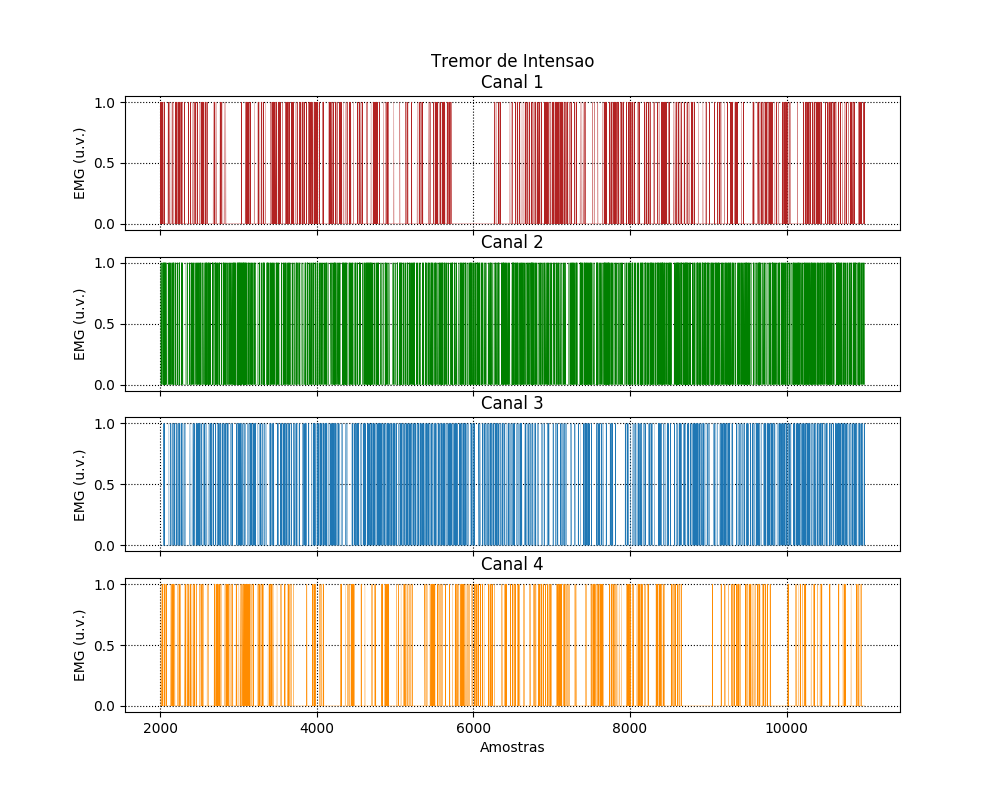

In [223]:
X = np.load('DB_REPO/preproc/PK_Osvaldir Borborema - Dia 17.11.18 as 15.15.13.edf_std.npy')
dfx = pd.DataFrame(data=X, columns=['Ch1','Ch2','Ch3','Ch4'])
X_e = zc(X,0.0)
dfe = pd.DataFrame(data=X_e, columns=['Ch1','Ch2','Ch3','Ch4'])
PlotFile(dfe[:11000])

In [213]:
print (dfe['Ch4'][2280:2360])

2280    0
2281    0
2282    0
2283    0
2284    1
2285    1
2286    0
2287    0
2288    0
2289    0
2290    0
2291    0
2292    0
2293    0
2294    0
2295    0
2296    0
2297    0
2298    0
2299    0
2300    0
2301    0
2302    0
2303    1
2304    1
2305    0
2306    0
2307    0
2308    0
2309    0
       ..
2330    0
2331    1
2332    0
2333    0
2334    0
2335    0
2336    0
2337    0
2338    0
2339    0
2340    0
2341    0
2342    1
2343    0
2344    1
2345    1
2346    1
2347    1
2348    0
2349    1
2350    0
2351    0
2352    0
2353    0
2354    0
2355    0
2356    0
2357    0
2358    0
2359    0
Name: Ch4, Length: 80, dtype: int64


In [214]:
print (dfx['Ch4'][2280:2360])

2280    0.007494
2281    0.008336
2282    0.010021
2283    0.007494
2284    0.000756
2285   -0.005141
2286    0.007494
2287    0.010863
2288    0.011706
2289    0.012548
2290    0.015075
2291    0.003282
2292    0.002440
2293    0.007494
2294    0.006652
2295    0.010021
2296    0.013390
2297    0.015917
2298    0.019287
2299    0.017602
2300    0.015917
2301    0.011706
2302    0.004125
2303    0.001598
2304   -0.000087
2305    0.008336
2306    0.012548
2307    0.013390
2308    0.010021
2309    0.004125
          ...   
2330    0.007494
2331    0.002440
2332   -0.004298
2333   -0.007668
2334   -0.011037
2335   -0.004298
2336   -0.000929
2337   -0.000087
2338   -0.003456
2339   -0.004298
2340   -0.009352
2341   -0.004298
2342   -0.001771
2343    0.000756
2344    0.003282
2345   -0.000087
2346    0.007494
2347   -0.002614
2348    0.002440
2349    0.001598
2350   -0.005141
2351   -0.015249
2352   -0.006825
2353   -0.004298
2354   -0.000929
2355   -0.000087
2356   -0.003456
2357   -0.0026

In [208]:
print (len(dfe['Ch1'][:11000]) - np.count_nonzero(dfe['Ch1'][:11000]==0))
print (len(dfe['Ch2'][:11000]) - np.count_nonzero(dfe['Ch2'][:11000]==0))
print (len(dfe['Ch3'][:11000]) - np.count_nonzero(dfe['Ch3'][:11000]==0))
print (len(dfe['Ch4'][:11000]) - np.count_nonzero(dfe['Ch4'][:11000]==0))

2069
2618
2286
1102


In [224]:
import collections, numpy

print collections.Counter(dfe['Ch1'][:11000])[1]
print collections.Counter(dfe['Ch2'][:11000])[1]
print collections.Counter(dfe['Ch3'][:11000])[1]
print collections.Counter(dfe['Ch4'][:11000])[1]

1314
2611
1416
894


In [193]:
981
1757
892
640

2069
2618
2286
1102


-1.0

---

---

# Testes com Peaks Detection

        Ch1       Ch2       Ch3       Ch4
0 -0.000215 -0.000047  0.000508 -0.000195
1 -0.000378  0.000051  0.000384 -0.000169
2 -0.000566  0.000098  0.000141 -0.000238
3 -0.000701  0.000100 -0.000549 -0.000388
4 -0.000685  0.000098 -0.001794 -0.000536


<IPython.core.display.Javascript object>


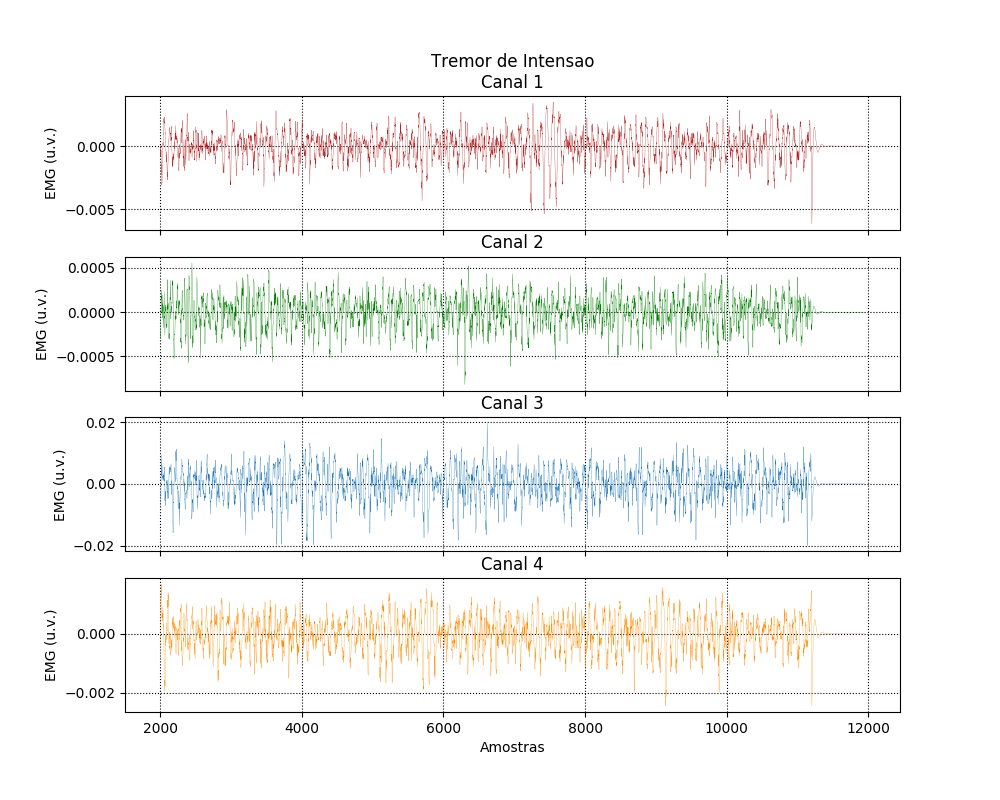

In [84]:
c = np.load('DB_REPO/preproc/CT_Antonia Perpetuo Borges - Dia 17.12.11 as 08.56.09.edf_filt.npy')

df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
print df.head()
PlotFile(df)

<IPython.core.display.Javascript object>


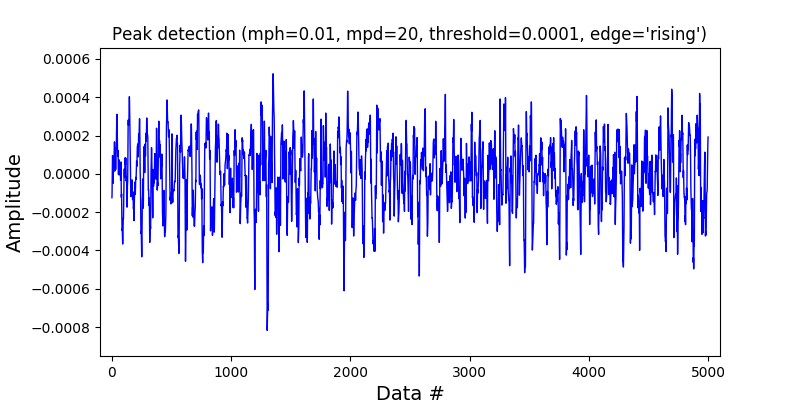

<IPython.core.display.Javascript object>


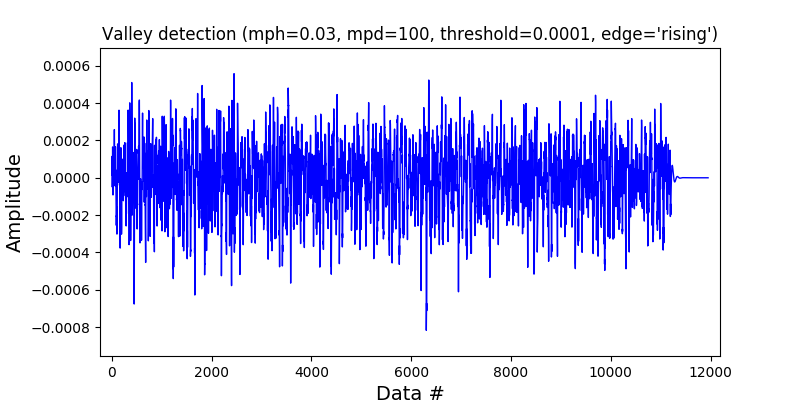

Total de picos: 


In [91]:
peak_p = detect_peaks(df['Ch2'][5000:10000], mph=0.01, mpd=20, threshold=0.0001, valley=False, show=True)
peak_n = detect_peaks(df['Ch2'][:20000], mph=0.03, mpd=100, threshold=0.0001, valley=True, show=True)

Peaks = len(peak_p) + len(peak_n)
print ('Total de picos: %.i' % Peaks)

        Ch1       Ch2       Ch3       Ch4
0  0.164779 -0.030123 -0.190785 -0.187583
1  0.062641 -0.179366 -0.084932 -0.045085
2 -0.011019 -0.439587 -0.038510  0.137898
3 -0.081150 -0.717241 -0.066445  0.365906
4 -0.207370 -0.814897 -0.127794  0.612137


<IPython.core.display.Javascript object>


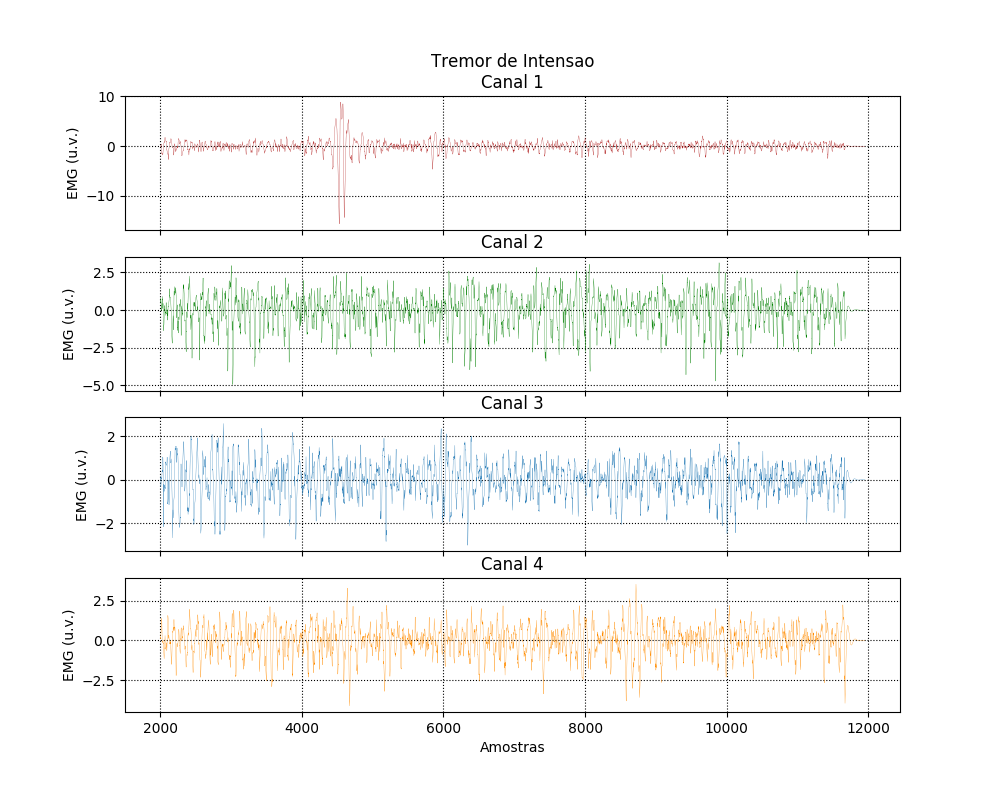

In [103]:
c = np.load('DB_REPO/preproc/Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf_filt.npy')

df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
print df.head()
PlotFile(df)

<IPython.core.display.Javascript object>


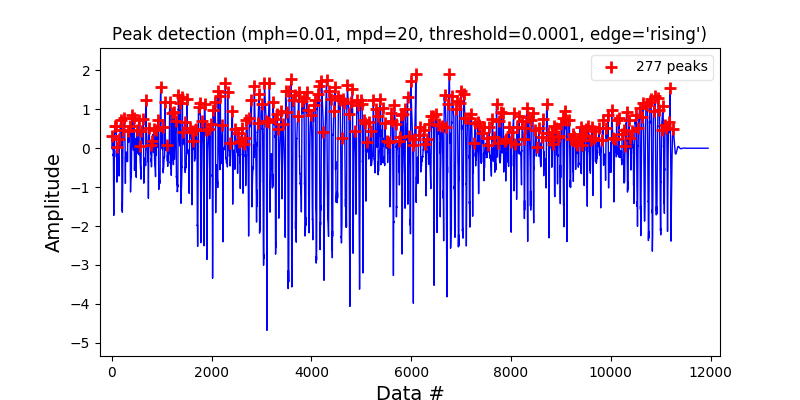

<IPython.core.display.Javascript object>


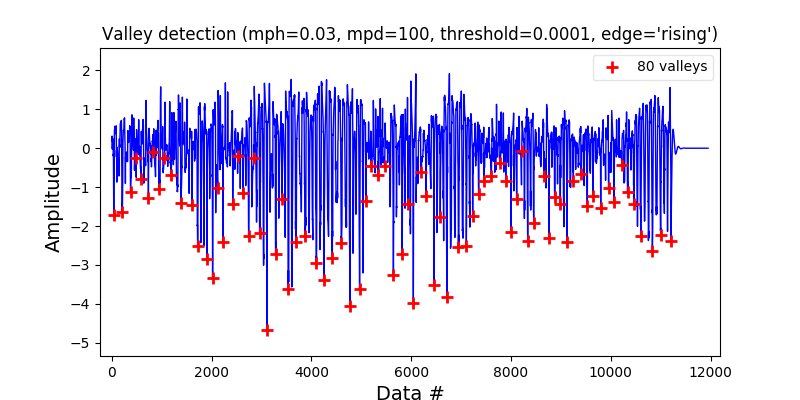

Total de picos: 357


In [231]:
peak_p = detect_peaks(df['Ch1'][:], mph=0.01, mpd=20, threshold=0.0001, valley=False, show=True)
peak_n = detect_peaks(df['Ch1'][:], mph=0.03, mpd=100, threshold=0.0001, valley=True, show=True)

Peaks = len(peak_p) + len(peak_n)
print ('Total de picos: %.i' % Peaks)

In [106]:
filtf = [
'Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_filt.npy',
'Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf_filt.npy',
'Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf_filt.npy',
'Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf_filt.npy',
'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf_filt.npy',
'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf_filt.npy',
'Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf_filt.npy',
'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf_filt.npy',
'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf_filt.npy',
'Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf_filt.npy',
'Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf_filt.npy',
'Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf_filt.npy',
'Donia Aires - Dia 17.11.25 as 16.39.51.edf_filt.npy',
'Donia Aires - Dia 17.11.25 as 16.40.23.edf_filt.npy',
'Donia Aires - Dia 17.11.25 as 16.40.42.edf_filt.npy',
'Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf_filt.npy',
'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf_filt.npy',
'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.32.edf_filt.npy',
'Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.35.edf_filt.npy',
'Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.56.edf_filt.npy',
'Gastao Goncalves da Silva - Dia 17.11.18 as 16.28.12.edf_filt.npy',
'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.28.edf_filt.npy',
'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.44.edf_filt.npy',
'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.59.09.edf_filt.npy',
'Ivanildes Barbosa - Dia 17.11.18 as 16.44.01.edf_filt.npy',
'Ivanildes Barbosa - Dia 17.11.18 as 16.44.19.edf_filt.npy',
'Ivanildes Barbosa - Dia 17.11.18 as 16.44.37.edf_filt.npy',
'Jose Fernandes Araujo - Dia 17.11.25 as 17.15.42.edf_filt.npy',
'Jose Fernandes Araujo - Dia 17.11.25 as 17.16.0.edf_filt.npy',
'Jose Fernandes Araujo - Dia 17.11.25 as 17.16.28.edf_filt.npy',
'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.21.edf_filt.npy',
'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.34.edf_filt.npy',
'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.49.edf_filt.npy',
'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.18.51.edf_filt.npy',
'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.07.edf_filt.npy',
'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.23.edf_filt.npy',
'Osvaldir Borborema - Dia 17.11.18 as 15.14.36.edf_filt.npy',
'Osvaldir Borborema - Dia 17.11.18 as 15.14.58.edf_filt.npy',
'Osvaldir Borborema - Dia 17.11.18 as 15.15.13.edf_filt.npy',
'Sergio Lamenza - Dia 17.11.25 as 16.58.15.edf_filt.npy',
'Sergio Lamenza - Dia 17.11.25 as 16.58.34.edf_filt.npy',
'Sergio Lamenza - Dia 17.11.25 as 16.59.00.edf_filt.npy',
]

In [250]:
filtf = ['Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_rms.npy']

<IPython.core.display.Javascript object>


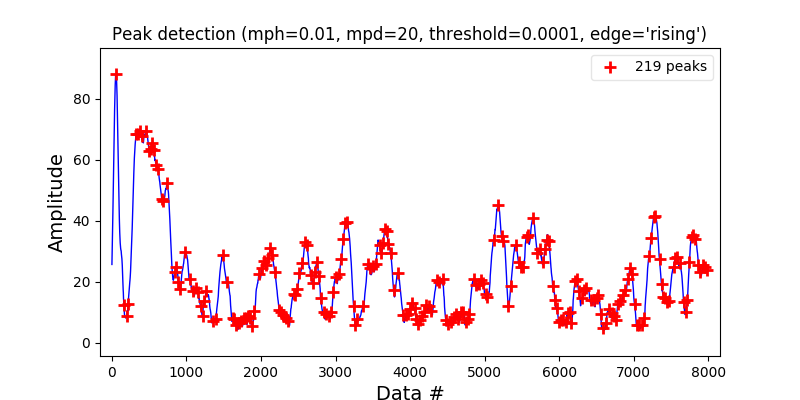

<IPython.core.display.Javascript object>


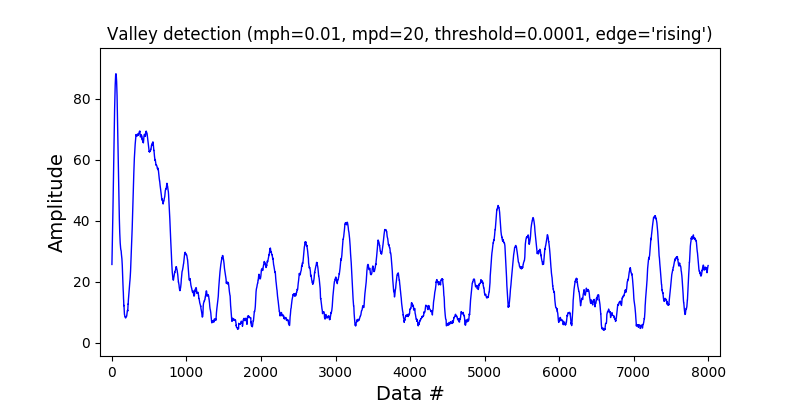

Total de picos: 219


In [251]:
P = []

for i in filtf[:1]:
    c = np.load('DB_REPO/preproc/'+i)
    df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
    peak_p = detect_peaks(df['Ch4'][2000:10000], mph=0.01, mpd=20, threshold=0.0001, valley=False, show=True)
    peak_n = detect_peaks(df['Ch4'][2000:10000], mph=0.01, mpd=20, threshold=0.0001, valley=True, show=True)

    Peaks = len(peak_p) + len(peak_n)
    print ('Total de picos: %.i' % Peaks)
    P.append(Peaks)


In [125]:
P

[391,
 385,
 410,
 511,
 496,
 515,
 426,
 477,
 454,
 422,
 394,
 418,
 428,
 441,
 516,
 440,
 434,
 501,
 416,
 406,
 409,
 381,
 393,
 344,
 418,
 421,
 424,
 342,
 349,
 326,
 475,
 475,
 493,
 428,
 447,
 446,
 405,
 439,
 425,
 327,
 362,
 347]

In [130]:
for i in range(0,len(P),3):
    print (sum(P[i:i+3]))/3
    

369
477
450
455
471
445
400
458
416
321
356
449
353
369


## Testes com PeakUtils

In [92]:
import peakutils
len(peakutils.indexes(df['Ch1'], thres=0.7, min_dist=1))

602

In [93]:
y = df['Ch1']
x = fs = np.linspace(0, 1,df['Ch1'].shape[0])

<IPython.core.display.Javascript object>


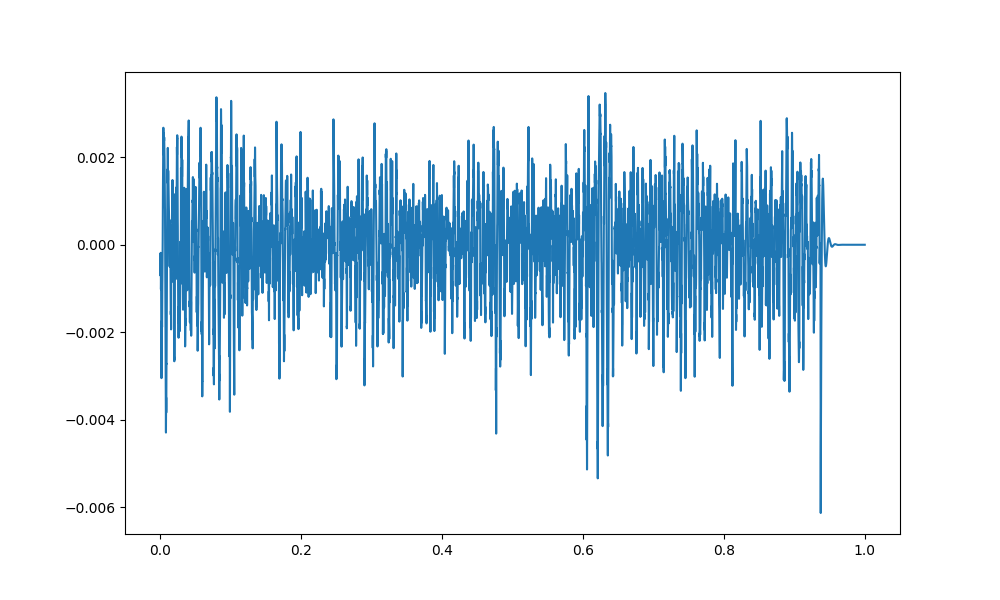

In [94]:
from peakutils.plot import plot as pplot
from matplotlib import pyplot

pyplot.figure(figsize=(10,6))
pyplot.plot(x, y)


<IPython.core.display.Javascript object>


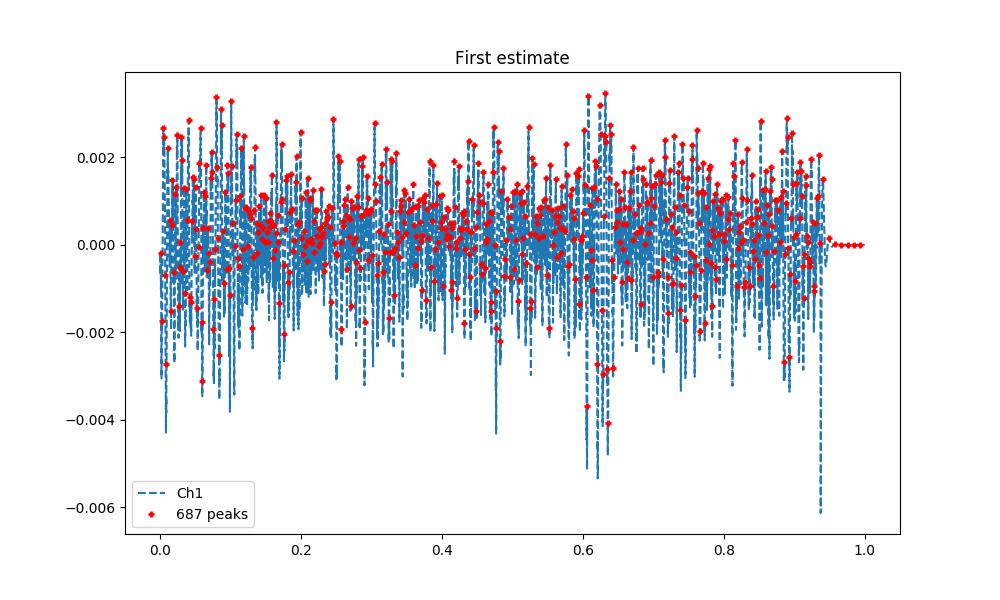

Text(0.5,1,u'First estimate')

In [98]:
indexes = peakutils.indexes(y, thres=0.2, min_dist=10)

pyplot.figure(figsize=(10,6))
pplot(x, y, indexes)
pyplot.title('First estimate')

<IPython.core.display.Javascript object>


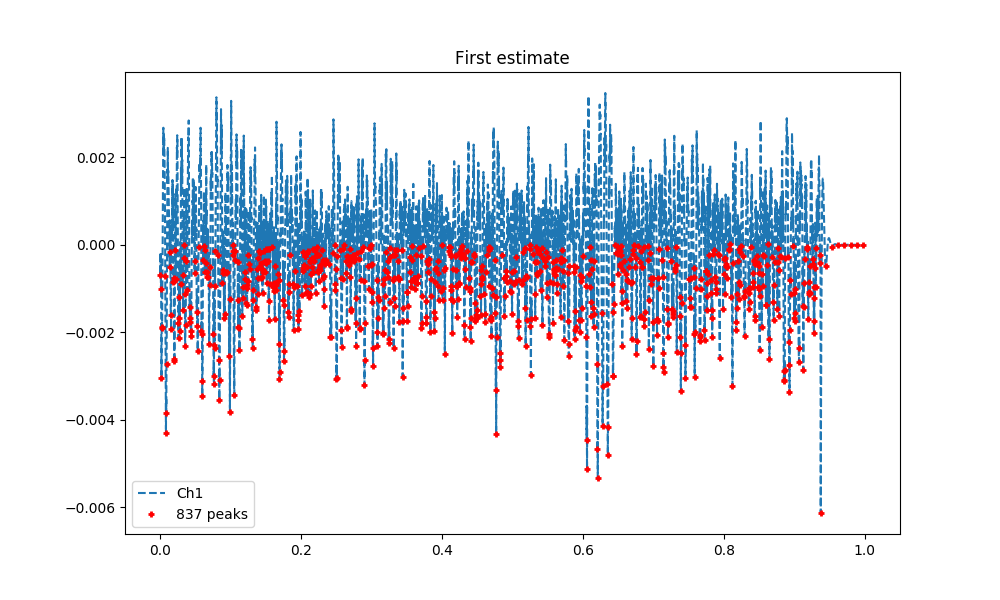

Text(0.5,1,u'First estimate')

In [95]:
indexes = peakutils.indexes(-y, thres=0.36, min_dist=1)

pyplot.figure(figsize=(10,6))
pplot(x, y, indexes)
pyplot.title('First estimate')

In [243]:
indexes

array([  11,   18,   80,   89,   97,  102,  117,  121,  165,  224,  314,
        421,  464,  519,  573,  628,  682,  740,  802,  806,  832,  836,
        894,  899,  904,  960,  963,  970,  977, 1040, 1045, 1107, 1169,
       1218, 1223, 1280, 1287, 1344, 1403, 1410, 1466, 1473, 1532, 1544,
       1606, 1612, 1680, 1686, 1695, 1765, 1774, 1788, 1797, 1861, 1871,
       1877, 1881, 1887, 1944, 1951, 1955, 2019, 2027, 2085, 2095, 2102,
       2163, 2173, 2182, 2189, 2251, 2326, 2338, 2342, 2347, 2412, 2417,
       2423, 2482, 2494, 2498, 2508, 2517, 2523, 2590, 2596, 2601, 2681,
       2689, 2693, 2702, 2770, 2833, 2838, 2890, 2896, 2964, 2973, 3033,
       3038, 3092, 3277, 3337, 3344, 3575, 3580, 3642, 3648, 3703, 3707,
       3755, 3761, 3812, 3818, 3866, 3875, 3932, 3979, 3984, 4042, 4099,
       4110, 4119, 4138, 4191, 4204, 4294, 4303, 4387, 4392, 4455, 4458,
       4515, 4581, 4638, 4650, 4714, 4727, 4788, 4791, 4804, 4862, 4870,
       4876, 4945, 4953, 4961, 5026, 5032, 5037, 50

In [266]:
rmsf = [
'Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_rms.npy',
'Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf_rms.npy',
'Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf_rms.npy',
'Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf_rms.npy',
'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf_rms.npy',
'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf_rms.npy',
'Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf_rms.npy',
'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf_rms.npy',
'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf_rms.npy',
'Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf_rms.npy',
'Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf_rms.npy',
'Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf_rms.npy',
'Donia Aires - Dia 17.11.25 as 16.39.51.edf_rms.npy',
'Donia Aires - Dia 17.11.25 as 16.40.23.edf_rms.npy',
'Donia Aires - Dia 17.11.25 as 16.40.42.edf_rms.npy',
'Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf_rms.npy',
'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf_rms.npy',
'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.32.edf_rms.npy',
'Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.35.edf_rms.npy',
'Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.56.edf_rms.npy',
'Gastao Goncalves da Silva - Dia 17.11.18 as 16.28.12.edf_rms.npy',
'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.28.edf_rms.npy',
'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.44.edf_rms.npy',
'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.59.09.edf_rms.npy',
'Ivanildes Barbosa - Dia 17.11.18 as 16.44.01.edf_rms.npy',
'Ivanildes Barbosa - Dia 17.11.18 as 16.44.19.edf_rms.npy',
'Ivanildes Barbosa - Dia 17.11.18 as 16.44.37.edf_rms.npy',
'Jose Fernandes Araujo - Dia 17.11.25 as 17.15.42.edf_rms.npy',
'Jose Fernandes Araujo - Dia 17.11.25 as 17.16.0.edf_rms.npy',
'Jose Fernandes Araujo - Dia 17.11.25 as 17.16.28.edf_rms.npy',
'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.21.edf_rms.npy',
'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.34.edf_rms.npy',
'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.49.edf_rms.npy',
'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.18.51.edf_rms.npy',
'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.07.edf_rms.npy',
'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.23.edf_rms.npy',
'Osvaldir Borborema - Dia 17.11.18 as 15.14.36.edf_rms.npy',
'Osvaldir Borborema - Dia 17.11.18 as 15.14.58.edf_rms.npy',
'Osvaldir Borborema - Dia 17.11.18 as 15.15.13.edf_rms.npy',
'Sergio Lamenza - Dia 17.11.25 as 16.58.15.edf_rms.npy',
'Sergio Lamenza - Dia 17.11.25 as 16.58.34.edf_rms.npy',
'Sergio Lamenza - Dia 17.11.25 as 16.59.00.edf_rms.npy',
]

In [284]:
P = []

for i in rmsf:
    c = np.load('DB_REPO/preproc/'+i)
    df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    y = df['Ch4']
    x = fs = np.linspace(0, 1,df['Ch4'].shape[0])
    indexes = peakutils.indexes(y, thres=0.01, min_dist=10)
    
    #pyplot.figure(figsize=(10,6))
    #pplot(x, y, indexes)
    
    P.append(len(indexes))


In [285]:
for i in range(0,len(P),3):
    print (sum(P[i:i+3]))/3
    

492
741
699
778
666
647
586
748
568
737
600
721
576
703
